In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def calc_price(theta1, theta2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2*theta1+theta2)/3. + cost
    p2 = (2*theta2+theta1)/3. + cost
    return p1, p2

def calc_t(theta1, theta2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(theta1, theta2, cost, wtp)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1,theta2,cost, wtp):
    t= calc_t(theta1, theta2, cost, wtp)
    p1,p2 = calc_price(theta1, theta2, cost, wtp)
    profits1, profits2 = t*(p1-theta1), (1-t)*(p2-theta2)
    hosp_profit = t*theta1 +  (1-t)*theta2
    return hosp_profit, profits1, profits2


def outside_simlt(theta1, theta2, cost, wtp):
    """outside option in simult case
    assuming listprice high enough"""
    if wtp < 8*cost/3:
        return 3.*wtp**2/(32.*cost)
    else:
        return (wtp-cost)/(2)
    return 


#arbitrary outside option...
def nash_in_nash(theta1, theta2, cost, wtp,beta=.5,seq=False):
    hosp_profit, profits1, profits2 = calc_profits(theta1, theta2,  cost,  wtp)
    outside = outside_simlt(theta1, theta2, cost, wtp)
    if seq:
        #print(outside)
        #print(theta1,theta2,'bargain_obj')
        outside = theta2
    obj = -1*(np.log(max(hosp_profit-outside,1e-4))*(1-beta) + np.log(profits1)*beta)
    return obj



COST = 10
WTP = 25

print(nash_in_nash(COST,COST, COST, WTP))

-1.5151423275303253


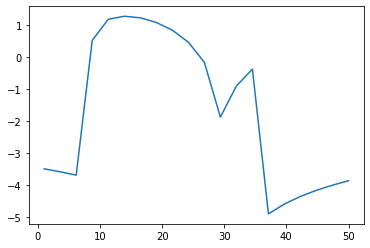

In [3]:
COST = 5
WTP  = 25
plt.plot([i for i in np.linspace(1,2*WTP,num=20)], 
         [-1*nash_in_nash(i, 15, COST,WTP) for i in np.linspace(1,2*WTP,num=20)])

In [4]:
def bargain_helper(theta1, theta2, cost, wtp,beta=.5):
    """solve each firm 1s optimization holding theta 2 fixed"""
    result = minimize(nash_in_nash, theta1, args=(theta2,cost, wtp, beta),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 25
print(bargain_helper(11.25,11.25, COST,WTP))

[13.52636719]


In [5]:
def simult_bargain(theta1, theta2, cost, wtp, betas=[.5,.5]):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, cost, wtp, betas[0])
        theta2 = bargain_helper(theta2, theta1, cost, wtp, betas[1])
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2

COST = 5
WTP  = 25
print(simult_bargain(11.25,11.25,COST,WTP))


(array([13.74998685]), array([13.75003069]))


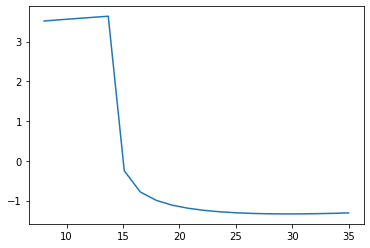

In [6]:
def bargain_helper_seq(theta1, cost, wtp,beta=.5):
    """ solve firm 1s optimization holding theta 2 fixed """

    result = minimize( nash_in_nash, 15., args=(theta1, cost, wtp, beta),
                      method='Nelder-Mead', options={'disp': False} )
    return result.x

def seq_obj(theta1, cost, wtp,betas=[.5,.5]):
    """ theta1 is a guess for the first stage """
    theta2 = bargain_helper_seq(theta1, cost, wtp, betas[1])

    return nash_in_nash(theta1, theta2, cost, wtp,betas[0],seq=True)


COST = 5
WTP = 25
plt.plot([i for i in np.linspace(COST+3,WTP +10,num=20)],  
         [seq_obj(i, 13.5 , WTP) for i in np.linspace(COST+3,WTP +10,num=20)])


In [7]:
def seq_bargain(theta1, cost, wtp,betas=[.5,.5]):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(cost, wtp,betas),
                      method='Nelder-Mead', options={'disp': False})
    
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, cost, wtp,beta=betas[1])
    return theta1, theta2

#WTP for insurer 

print(seq_bargain(19,5,25))
print(calc_profits(19.375,15.625,25,5))
print(seq_bargain(19,5,26))
print(calc_profits(19.375,15.625,26,5))

(array([19.37503662]), array([15.62502572]))
(17.40625, 11.28125, 13.78125)
(array([19.87496948]), array([16.12500042]))
(17.409855769230766, 11.780048076923077, 14.280048076923078)


In [12]:
def make_table(arg, steps, params,betas=[.5,.5]):
    """the argument is 
    args =  0 -cost, 1 - wtp
    steps = min_arg, max_arg, no_step """
    
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','listprice','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    
    for eq_type in ['Simultaneous', 'Sequential']:
        result1 = []
        result2 = []
        for var in indep_var:
        
            param_copy = list(params)
            param_copy[arg] = var
            cost,wtp = param_copy
            
            mc1,mc2 = 20,20
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1, mc2, cost, wtp,betas=betas)
            else:
                mc1,mc2 = seq_bargain(mc1, cost, wtp,betas=betas)
            
            s1 = calc_t(mc1,mc2, cost,wtp)
            s2 = (1-s1)
            p1,p2 = calc_price(mc1,mc2,cost,wtp)
            pi_h,pi1,pi2 = calc_profits(mc1,mc2,cost, wtp)
            cons1 = wtp - s1*cost - p1
            cons2 = wtp - s2*cost - p2

            result1.append( (wtp, mc1, p1, pi1,  pi_h) ) 
            result2.append( (wtp, mc2, p2, pi2,  pi_h) ) 
        print('\n',eq_type, '\n')
        
        for line in result1:
            print("%.3f & %.3f  & %.3f  & %.3f  & %.3f  \\\\"%line)
            
        print('\n')
        
        for line in result2:
            print("%.3f & %.3f  & %.3f  & %.3f  & %.3f   \\\\"%line)
            
#make_table(0, (5,7,3), (5,25),betas=[.5,.5])
make_table(1, (25,30,6), (5,25),betas=[.5,.5])


 Simultaneous 

25.000 & 13.750  & 18.750  & 2.500  & 13.750  \\
26.000 & 14.250  & 19.250  & 2.500  & 14.250  \\
27.000 & 14.750  & 19.750  & 2.500  & 14.750  \\
28.000 & 15.250  & 20.250  & 2.500  & 15.250  \\
29.000 & 15.750  & 20.750  & 2.500  & 15.750  \\
30.000 & 16.250  & 21.250  & 2.500  & 16.250  \\


25.000 & 13.750  & 18.750  & 2.500  & 13.750   \\
26.000 & 14.250  & 19.250  & 2.500  & 14.250   \\
27.000 & 14.750  & 19.750  & 2.500  & 14.750   \\
28.000 & 15.250  & 20.250  & 2.500  & 15.250   \\
29.000 & 15.750  & 20.750  & 2.500  & 15.750   \\
30.000 & 16.250  & 21.250  & 2.500  & 16.250   \\

 Sequential 

25.000 & 19.375  & 23.125  & 1.406  & 17.031  \\
26.000 & 19.875  & 23.625  & 1.406  & 17.531  \\
27.000 & 20.375  & 24.125  & 1.406  & 18.031  \\
28.000 & 20.875  & 24.625  & 1.406  & 18.531  \\
29.000 & 21.375  & 25.125  & 1.406  & 19.031  \\
30.000 & 21.875  & 25.625  & 1.406  & 19.531  \\


25.000 & 15.625  & 21.875  & 3.906  & 17.031   \\
26.000 & 16.125  & 22.375 